<Axes: >

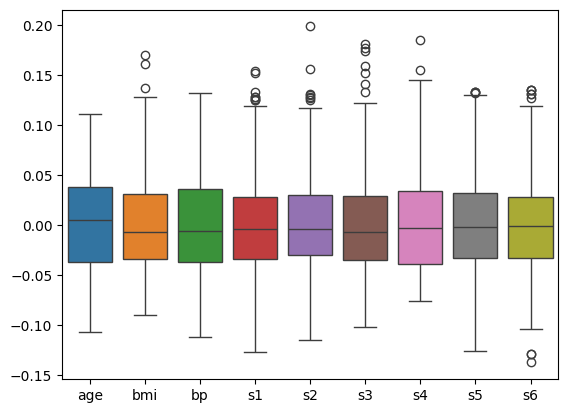

In [89]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

X, y = datasets.load_diabetes(as_frame=True, return_X_y=True)

sns.boxplot(data=X.drop(columns='sex'))

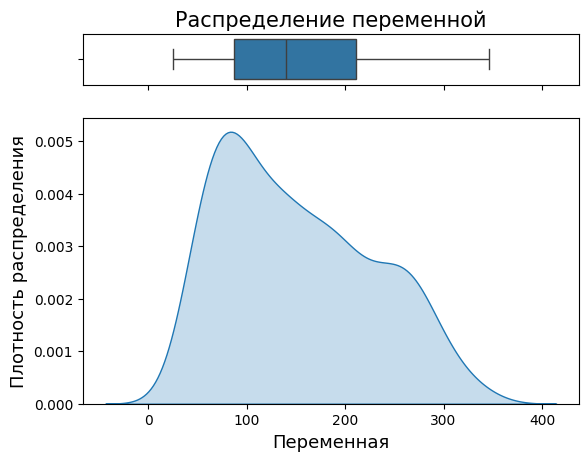

In [90]:
f, (ax_box, ax_kde) = plt.subplots(nrows = 2, # из двух строк
                                    ncols = 1, # и одного столбца
                                    sharex = True, # оставим только нижние подписи к оси x
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # зададим разную высоту строк

# в первом подграфике построим boxplot
sns.boxplot(x = y, ax = ax_box)
ax_box.set(xlabel = None)
# во втором - график плотности распределения
sns.kdeplot(y, fill = True)

# зададим заголовок и подписи к осям
ax_box.set_title('Распределение переменной', fontsize = 15)
ax_kde.set_xlabel('Переменная', fontsize = 13)
ax_kde.set_ylabel('Плотность распределения', fontsize = 13)
 
plt.show()

In [91]:
data = pd.merge(X, y, left_index=True, right_index=True)

st, p = stats.pointbiserialr(X.sex, y)
print(st)

data.corr().target.to_frame().style.background_gradient()

0.04306199845160541


,target
age,0.187889
sex,0.043062
bmi,0.586450
bp,0.441482
s1,0.212022
s2,0.174054
s3,-0.394789
s4,0.430453
s5,0.565883
s6,0.382483


In [92]:
data.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [93]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(data)

data['anomaly'] = clf.predict(data)
data = data[data.anomaly == 1]
data = data.drop(columns='anomaly')
data.shape


(379, 11)

In [94]:
X = data.drop('target', axis=1)
y = data['target']

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

model = LinearRegression()
y_pred = model.fit(X, y).predict(X)

MSE = metrics.root_mean_squared_error(y, y_pred) # стандартное отклонение
MAE = metrics.mean_absolute_error(y, y_pred) # средняя абсолютная ошибка (между предсказанным и истинным значением)
MAPE = metrics.mean_absolute_percentage_error(y, y_pred) # средняя абсолютная ошибка в процентах
R2 = metrics.r2_score(y, y_pred)

print(f'MSE = {MSE}\nMAE = {MAE}\nMAPE = {MAPE}\nR2 = {R2}')

MSE = 53.35883250418729
MAE = 42.978347675482475
MAPE = 0.3920592635084205
R2 = 0.45558153269194757


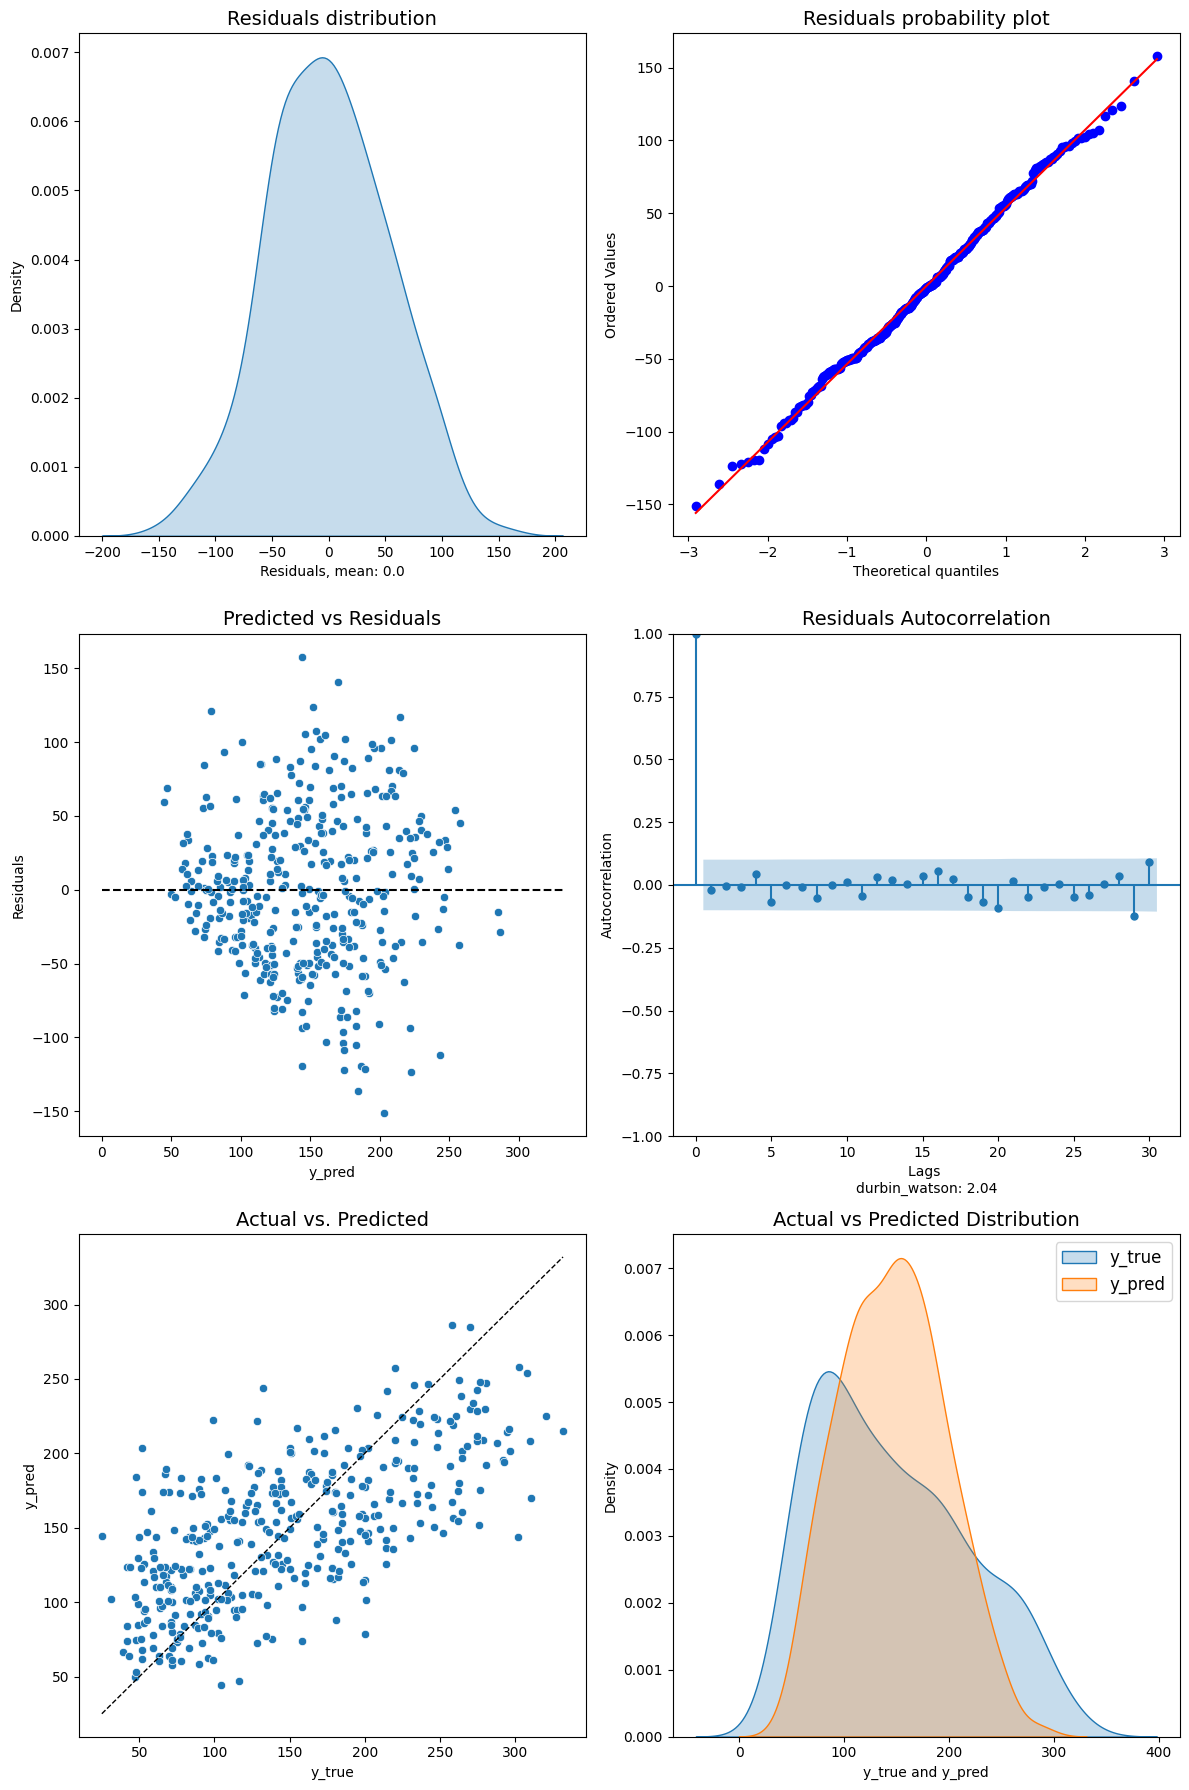

In [95]:
from user_modules.diag_LR_model import diagnostics_LR_model

diagnostics_LR_model(y, y_pred)

In [96]:
'''
расчет коэффициента инфляции дисперсии VIF для обнаружения степени
мультиколлинеарности в MLR
'''

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

c = add_constant(X.drop('sex', axis=1))

VIFs = pd.DataFrame()
VIFs['Variable'] = c.columns
VIFs['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
VIFs

c = add_constant(X.drop(['sex', 's1'], axis=1)) # удалим признак с наибольшим VIF

VIFs = pd.DataFrame()
VIFs['Variable'] = c.columns
VIFs['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
VIFs

,Variable,VIF
0,const,1.055374
1,age,1.233194
2,bmi,1.399882
3,bp,1.361536
4,s2,3.066368
5,s3,4.189168
6,s4,8.071196
7,s5,1.958954
8,s6,1.390561


In [97]:
data = data.drop('s1', axis=1)

In [98]:
from sklearn.preprocessing import PowerTransformer
 
pt = PowerTransformer()
new_data = pd.DataFrame(pt.fit_transform(data),
                      columns = data.columns)

new_data.head()

,age,sex,bmi,bp,s2,s3,s4,s5,s6,target
0,0.783450,1.091216,1.374543,0.598102,-0.825522,-1.096935,0.165716,0.576169,-0.333770,0.227807
1,-0.119989,-0.916409,-1.222769,-0.489869,-0.409694,1.588011,-0.905102,-1.542789,-2.073472,-1.023844
2,1.977805,1.091216,1.070017,-0.002082,-0.808588,-0.770699,0.165716,0.181312,-0.523717,0.093098
3,-1.792676,-0.916409,-0.128959,-0.746489,0.681056,-0.877423,1.032865,0.639931,-0.144672,0.874864
4,0.037277,-0.916409,-0.782346,0.598102,0.458732,0.278966,0.165716,-0.647459,-1.002275,0.009053


In [99]:
new_data.drop(columns='sex').corr().target.to_frame().style.background_gradient()

,target
age,0.193645
bmi,0.516844
bp,0.374357
s2,0.180037
s3,-0.372122
s4,0.418945
s5,0.527536
s6,0.300625
target,1.000000


In [100]:
st, p = stats.pointbiserialr(new_data.sex, new_data.target)
print(st)

-0.004302366971818017


In [101]:
X = new_data.drop(columns=['age', 'sex', 'bp', 's2', 's3', 's4', 's6'])
y = new_data.target

from sklearn.linear_model import LinearRegression
 
model = LinearRegression()
y_pred = model.fit(X, y).predict(X)

MAPE = metrics.mean_absolute_percentage_error(y, y_pred) # средняя абсолютная ошибка в процентах
R2 = metrics.r2_score(y, y_pred)

print(f'MAPE = {MAPE}\nR2 = {R2}')

MAPE = 4.481042905107582e-16
R2 = 1.0


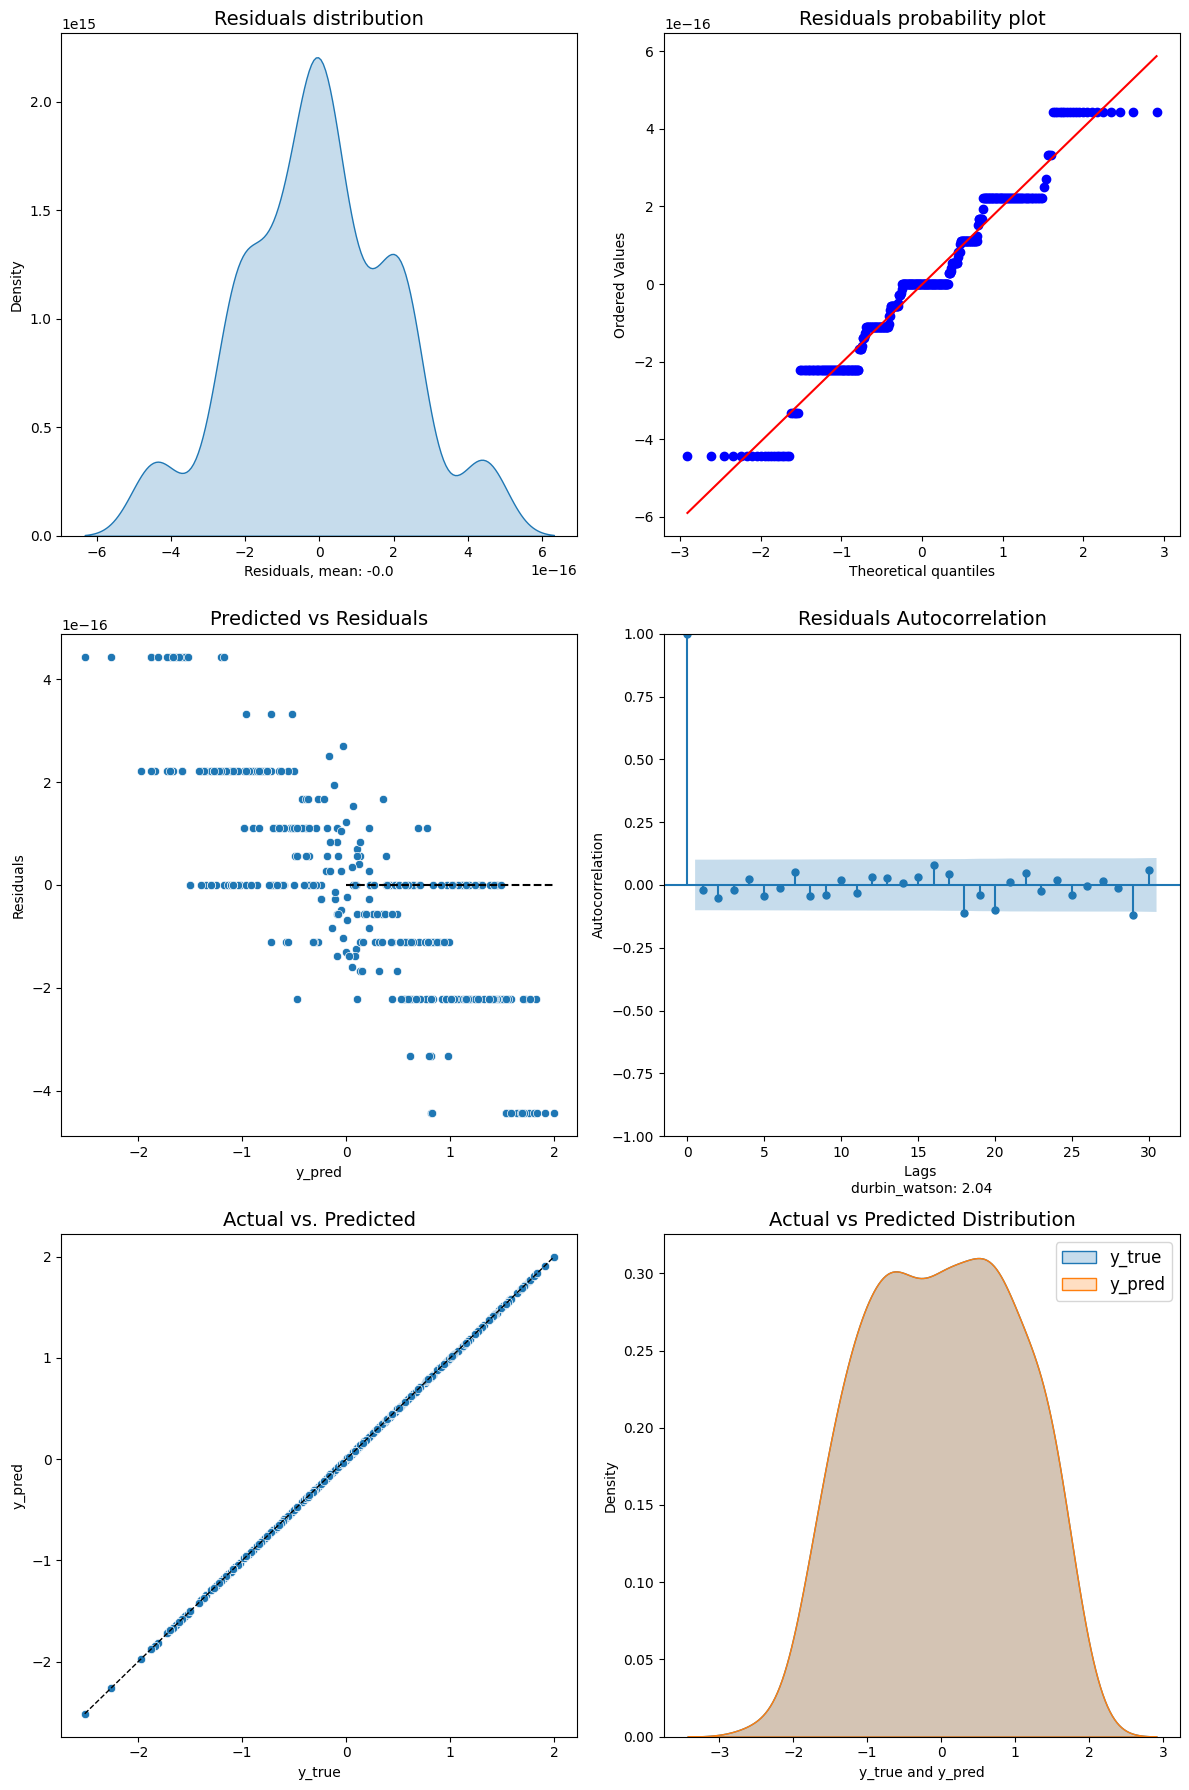

In [102]:
diagnostics_LR_model(y, y_pred)